# Copyright Netherlands eScience Center <br>
**Function     : Loss function scaling factor tuning of BayesConvLSTM with Lorens-84 model** <br>
**Author       : Yang Liu** <br>
**First Built  : 2020.04.30** <br>
**Last Update  : 2020.05.08** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to help understand the uncertainty generated by BayesConvLSTM with the sensitivity tests with Lorens 84 model. <br>

Three different types of uncertainties will vbe investigated here:<br>
- uncertainty of model outcome attributed to perturbation in initial conditions
- model uncertainty
- uncertainty related to extra/bias/trend terms

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [12]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# sensitivity test parameter
sense = 'x'
# model type
model_type = 'lorenz84' # choose lorenz84 or lorenz84ex
# datapath for output
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84'
# data path of experiment
data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\x_001\\lorenz'
# datapath of forecast
pred_lorenz_bayesconvlstm_path_p1 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\penalty1'
pred_lorenz_bayesconvlstm_path_p10 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\penalty10'
pred_lorenz_bayesconvlstm_path_p50 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\penalty50'
pred_lorenz_bayesconvlstm_path_p100 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\penalty100'
pred_lorenz_bayesconvlstm_F_path_p100 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\F_penalty100'
pred_lorenz_bayesconvlstm_path_p100_stdx2 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\penalty100_stdx2'
pred_lorenz_bayesconvlstm_path_p100_stdx4 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\penalty100_stdx4'

In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # name the ensemble member
    ens_num = 0
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 1500
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 200

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>

##### Testing 
- Testing initial conditions x, y, z - uncertainty of model outcome <br>
**starting point x=1.0, y=1.0, z=1.0** <br>
Ensemble variant x 50 members <br>
x = [1.0020 : 0.9980] **~0.2%**<br>
x = [1.0010 : 0.9990] **~0.1%**<br>
x = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.0010 : 0.9990] **~0.1%**<br>
x_ex = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.000010 : 0.999990] **~0.001%**<br>
========================================================================================================<br>
- Testing model parameters a & b - model uncertainty <br>
**starting point a=0.25, b=4.0** <br>
Ensemble variant a <br>
a = [0.25010 : 0.24990] **~0.04%**<br>
a_ex = [0.250010 : 0.249990] **~0.004%**<br>
a_ex = [0.2500010 : 0.2499990] **~0.0004%**<br>
========================================================================================================<br>
- Testing external forcing terms F & G - uncertainty related to extra/bias/trend terms <br>
**starting point F=8.0, G=1.0** <br>
Ensemble variant G <br>
G = [1.0010 : 0.9990] **~0.1%**<br>
G_ex = [1.00010 : 0.99990] **~0.01%**<br>
G_ex = [1.000010 : 0.999990] **~0.001%**<br>
**starting point F=8.0, G=1.0, epsilon=0.4** <br>

In [5]:
    #################################################################################
    ###########                     Lorens 84 model                       ###########
    #################################################################################    
    def lorenz84(x, y, z, a = 0.25, b = 4.0, F = 8.0, G = 1.0):
        """
        Solver of Lorens-84 model.
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        Physical interpretation:
        x represents the intensity of the symmetric globe-encircling westerly
        wind current, and also the poleward temperature gradient, which is assumed
        to be in permanent equilibrium with it.
        
        y and z represent the cosine and sine phases of a chain of superposed
        large-scale eddies, which transport heat poleward at a rate proportional
        to the square of their amplitude, and transport no angular momentum at all.
        (Lorenz identifies the eddies with Rossby waves!)
        
        xy and xz these nonlinear contributions represent amplification of the
        eddies through interaction with the westerly current
        
        -y**2 and -z**2 are the expense of the westerly current for the amplification
        of the eddies.
        
        -bxz and bxy represent displacement of the eddies by the westerly current.
        
        b allows the amplification (should be b>1.0)
        
        a represents mechanical and thermal damping(should be a>1.0).
        
        aF represents symmetric thermal forcing
        G represents asymmetric thermal forcing
        
        !@#$%^&* The variables have been scaled so that the coefficients are unity.
        
        Freire, J. G., Bonatto, C., DaCamara, C. C., & Gallas, J. A. (2008).
        Multistability, phase diagrams, and intransitivity in the Lorenz-84
        low-order atmospheric circulation model. Chaos: An Interdisciplinary
        Journal of Nonlinear Science, 18(3), 033121.
        """
        dx = - y**2 - z**2 - a * x + a * F
        dy = x * y - b * x * z - y + G
        dz = b * x * y + x * z - z
        
        return dx, dy, dz
    
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 1.0):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########                 Launch Lorenz 84 model                    ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84(x[i], y[i], z[i], a, b ,F, G)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

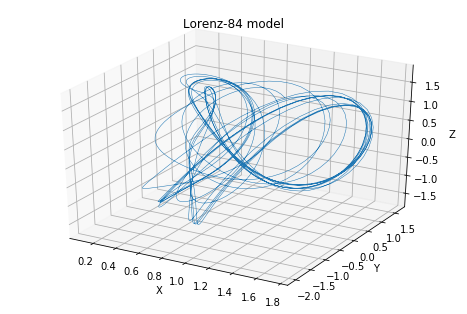

<Figure size 432x288 with 0 Axes>

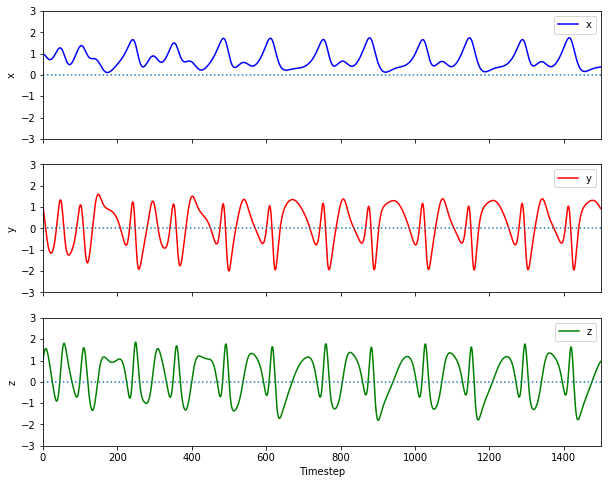

In [7]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                    ###########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.show()

    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()

===================  load data  =====================
===================  visualize data  =====================
===================  whole time series  =====================


<Figure size 432x288 with 0 Axes>

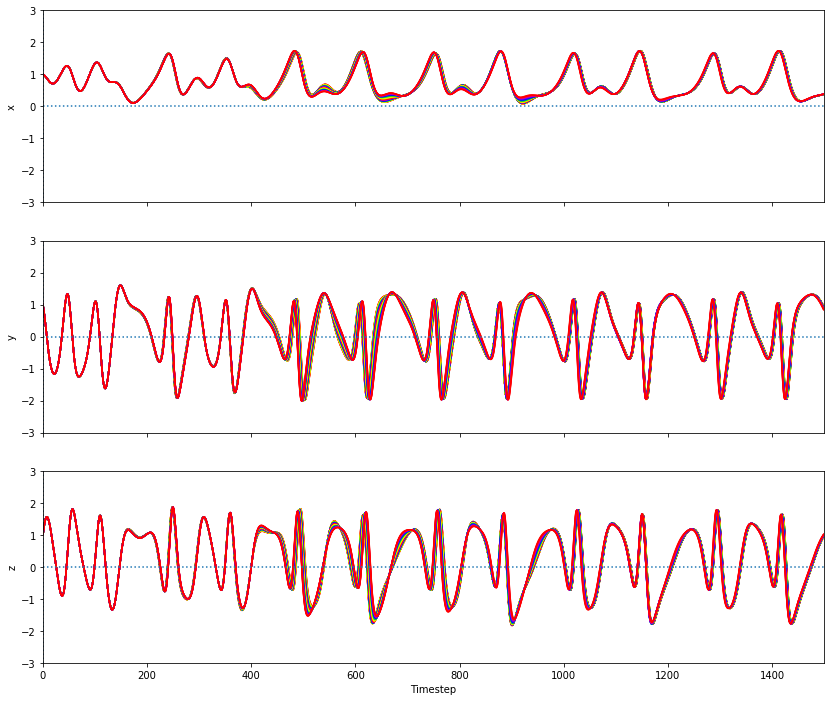

===================  testing period time series  =====================


<Figure size 432x288 with 0 Axes>

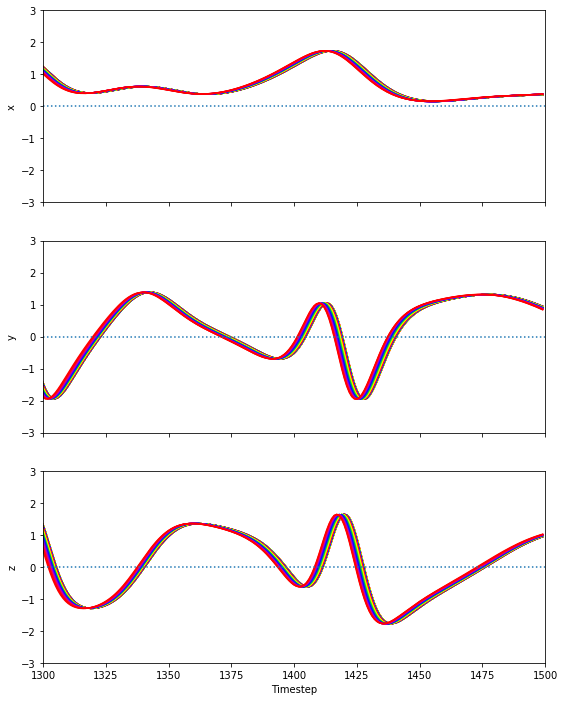

In [8]:
    #################################################################################
    ###########        Precheck Lorenz 84 model ensemble output           ###########
    #################################################################################
    print ('===================  load data  =====================')
    # save Lorens model output
    index = np.arange(num_steps)
    # number of ensembles
    ens = 51
    data_ens = np.zeros((ens, 3, num_steps), dtype=float)
    # load data
    for i in range(ens):
        dataset = Dataset(os.path.join(data_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
        #extract data
        data_ens[i,:,:] = dataset.variables['series'][:]
    
    print ('===================  visualize data  =====================')
    #colormap=cm.Pastel2(range(ens))
    #colormap=cm.hsv(range(ens))
    colormap=cm.prism(range(ens))
    #colormap=cm.gist_ncar(range(ens))
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', 51)
    #colormap = plt.get_cmap('jet', 51)
    
    print ('===================  whole time series  =====================')
    fig02 = plt.figure()
    fig02, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig02.set_size_inches(14, 12, forward=True)
    for i in range(ens):
        ax1.plot(index, data_ens[i, 0, :], color=colormap[i], label='x-ens-{}'.format(i))
        ax2.plot(index, data_ens[i, 1, :], color=colormap[i], label='y-ens-{}'.format(i))
        ax3.plot(index, data_ens[i, 2, :], color=colormap[i], label='z-ens-{}'.format(i))
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')

    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    #ax1.legend(frameon=True, loc=3, prop={'size': 11}, ncol=6)
    #ax2.legend(frameon=True, loc=3, prop={'size': 11}, ncol=6)
    #ax3.legend(frameon=True, loc=3, prop={'size': 11}, ncol=6)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")

    plt.show()

    print ('===================  testing period time series  =====================')
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(9, 12, forward=True)
    for i in range(ens):
        ax1.plot(index[-test_len:], data_ens[i, 0, -test_len:], color=colormap[i], label='x-ens-{}'.format(i))
        ax2.plot(index[-test_len:], data_ens[i, 1, -test_len:], color=colormap[i], label='y-ens-{}'.format(i))
        ax3.plot(index[-test_len:], data_ens[i, 2, -test_len:], color=colormap[i], label='z-ens-{}'.format(i))
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(num_steps-test_len, num_steps)
    ax2.set_xlim(num_steps-test_len, num_steps)
    ax3.set_xlim(num_steps-test_len, num_steps)
    
    #ax1.legend(frameon=True, loc=3, prop={'size': 8}, ncol=6)
    #ax2.legend(frameon=True, loc=3, prop={'size': 8}, ncol=6)
    #ax3.legend(frameon=True, loc=3, prop={'size': 8}, ncol=6)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")    

    plt.show()      

# Forecast with BayesConvLSTM <br>
** We use Pytorth to implement BayesConvLSTM neural network to deal with the Lorenz 84 model output. ** <br>

In [9]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


# Postprocess forecast data <br>
** Postprocess and visualization of ensemble forecast data ** <br>

In [10]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    step_lead = 16 # unit week
    # number of ensembles
    ens = 20
    predictand_p1 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_p10 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_p50 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_p100 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_F_p100 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_p100_stdx2 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_p100_stdx4 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    for i in range(ens):
        dataset_pred_p1 = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path_p1,
                                            'pred_lorenz84_ens_{}.nc'.format(i)))
        dataset_pred_p10 = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path_p10,
                                            'pred_lorenz84_ens_{}.nc'.format(i)))
        dataset_pred_p50 = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path_p50,
                                            'pred_lorenz84_ens_{}.nc'.format(i)))
        dataset_pred_p100 = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path_p100,
                                            'pred_lorenz84_ens_{}.nc'.format(i)))
        dataset_pred_F_p100 = Dataset(os.path.join(pred_lorenz_bayesconvlstm_F_path_p100,
                                            'pred_lorenz84_ens_{}.nc'.format(i)))
        dataset_pred_p100_stdx2 = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path_p100_stdx2,
                                            'pred_lorenz84_ens_{}.nc'.format(i)))
        dataset_pred_p100_stdx4 = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path_p100_stdx4,
                                            'pred_lorenz84_ens_{}.nc'.format(i)))
        predictand_p1[i,:,:,:] = dataset_pred_p1.variables['series'][:]
        predictand_p10[i,:,:,:] = dataset_pred_p10.variables['series'][:]
        predictand_p50[i,:,:,:] = dataset_pred_p50.variables['series'][:]
        predictand_p100[i,:,:,:] = dataset_pred_p100.variables['series'][:]
        predictand_F_p100[i,:,:,:] = dataset_pred_F_p100.variables['series'][:]
        predictand_p100_stdx2[i,:,:,:] = dataset_pred_p100_stdx2.variables['series'][:]
        predictand_p100_stdx4[i,:,:,:] = dataset_pred_p100_stdx4.variables['series'][:]
    #print(predictand.shape)
    predictand_median_p1 = np.median(predictand_p1, 0)
    predictand_median_p10 = np.median(predictand_p10, 0)
    predictand_median_p50 = np.median(predictand_p50, 0)
    predictand_median_p100 = np.median(predictand_p100, 0)
    predictand_F_median_p100 = np.median(predictand_F_p100, 0)
    predictand_median_p100_stdx2 = np.median(predictand_p100_stdx2, 0)
    predictand_median_p100_stdx4 = np.median(predictand_p100_stdx4, 0)

*******************  load ensemble data  *********************


===================  visualize data  =====================


<Figure size 432x288 with 0 Axes>

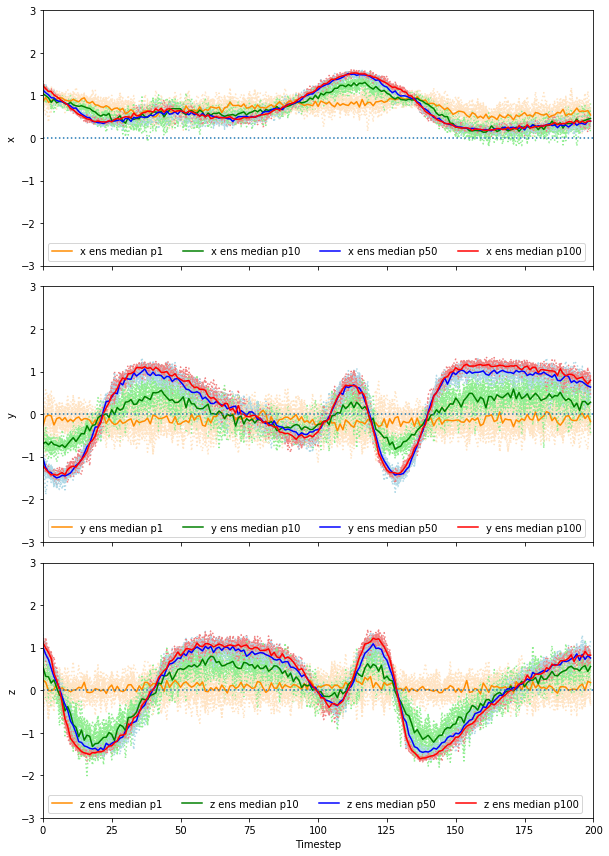

In [14]:
    #######################################################################################
    ########    visualization of lead time dependent prediction - scaling factor   ########
    #######################################################################################
    index = np.arange(test_len) 
    print ('===================  visualize data  =====================')
    
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(9, 12, forward=True)
    # each member
    for i in range(ens):
        ax1.plot(index, predictand_p1[i, 0, :, 0] * (x_max - x_min) + x_min,
                 color='bisque', linestyle='dotted')
        ax2.plot(index, predictand_p1[i, 1, :, 0] * (y_max - y_min) + y_min,
                 color='bisque', linestyle='dotted')
        ax3.plot(index, predictand_p1[i, 2, :, 0] * (z_max - z_min) + z_min,
                 color='bisque', linestyle='dotted')

        ax1.plot(index, predictand_p10[i, 0, :, 0] * (x_max - x_min) + x_min,
                 color='lightgreen', linestyle='dotted')
        ax2.plot(index, predictand_p10[i, 1, :, 0] * (y_max - y_min) + y_min,
                 color='lightgreen', linestyle='dotted')
        ax3.plot(index, predictand_p10[i, 2, :, 0] * (z_max - z_min) + z_min,
                 color='lightgreen', linestyle='dotted')

        ax1.plot(index, predictand_p50[i, 0, :, 0] * (x_max - x_min) + x_min,
                 color='lightblue', linestyle='dotted')
        ax2.plot(index, predictand_p50[i, 1, :, 0] * (y_max - y_min) + y_min,
                 color='lightblue', linestyle='dotted')
        ax3.plot(index, predictand_p50[i, 2, :, 0] * (z_max - z_min) + z_min,
                 color='lightblue', linestyle='dotted')
        
        ax1.plot(index, predictand_p100[i, 0, :, 0] * (x_max - x_min) + x_min,
                 color='lightcoral', linestyle='dotted')
        ax2.plot(index, predictand_p100[i, 1, :, 0] * (y_max - y_min) + y_min,
                 color='lightcoral', linestyle='dotted')
        ax3.plot(index, predictand_p100[i, 2, :, 0] * (z_max - z_min) + z_min,
                 color='lightcoral', linestyle='dotted')

#         ax1.plot(index, predictand_F_p100[i, 0, :, 0] * (x_max - x_min) + x_min,
#                  color='violet', linestyle='dotted')
#         ax2.plot(index, predictand_F_p100[i, 1, :, 0] * (y_max - y_min) + y_min,
#                  color='violet', linestyle='dotted')
#         ax3.plot(index, predictand_F_p100[i, 2, :, 0] * (z_max - z_min) + z_min,
#                  color='violet', linestyle='dotted')
    # median
    ax1.plot(index, predictand_median_p1[0, :, 0] * (x_max - x_min) + x_min,
             color='darkorange', linestyle='solid', label='x ens median p1')
    ax2.plot(index, predictand_median_p1[1, :, 0] * (y_max - y_min) + y_min,
             color='darkorange', linestyle='solid', label='y ens median p1')
    ax3.plot(index, predictand_median_p1[2, :, 0] * (z_max - z_min) + z_min,
             color='darkorange', linestyle='solid', label='z ens median p1')

    ax1.plot(index, predictand_median_p10[0, :, 0] * (x_max - x_min) + x_min,
             color='green', linestyle='solid', label='x ens median p10')
    ax2.plot(index, predictand_median_p10[1, :, 0] * (y_max - y_min) + y_min,
             color='green', linestyle='solid', label='y ens median p10')
    ax3.plot(index, predictand_median_p10[2, :, 0] * (z_max - z_min) + z_min,
             color='green', linestyle='solid', label='z ens median p10')

    ax1.plot(index, predictand_median_p50[0, :, 0] * (x_max - x_min) + x_min,
             color='blue', linestyle='solid', label='x ens median p50')
    ax2.plot(index, predictand_median_p50[1, :, 0] * (y_max - y_min) + y_min,
             color='blue', linestyle='solid', label='y ens median p50')
    ax3.plot(index, predictand_median_p50[2, :, 0] * (z_max - z_min) + z_min,
             color='blue', linestyle='solid', label='z ens median p50')
    
    ax1.plot(index, predictand_median_p100[0, :, 0] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x ens median p100')
    ax2.plot(index, predictand_median_p100[1, :, 0] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y ens median p100')
    ax3.plot(index, predictand_median_p100[2, :, 0] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z ens median p100')
    
#     ax1.plot(index, predictand_F_median_p100[0, :, 0] * (x_max - x_min) + x_min,
#              color='magenta', linestyle='solid', label='x ens median F p100')
#     ax2.plot(index, predictand_F_median_p100[1, :, 0] * (y_max - y_min) + y_min,
#              color='magenta', linestyle='solid', label='y ens median F p100')
#     ax3.plot(index, predictand_F_median_p100[2, :, 0] * (z_max - z_min) + z_min,
#              color='magenta', linestyle='solid', label='z ens median F p100')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10}, ncol=4)
    ax2.legend(frameon=True, loc=3, prop={'size': 10}, ncol=4)
    ax3.legend(frameon=True, loc=3, prop={'size': 10}, ncol=4)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()

    plt.show()
    fig03.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_ens_comp_penalty.png'),dpi=200)

===================  visualize data  =====================


<Figure size 432x288 with 0 Axes>

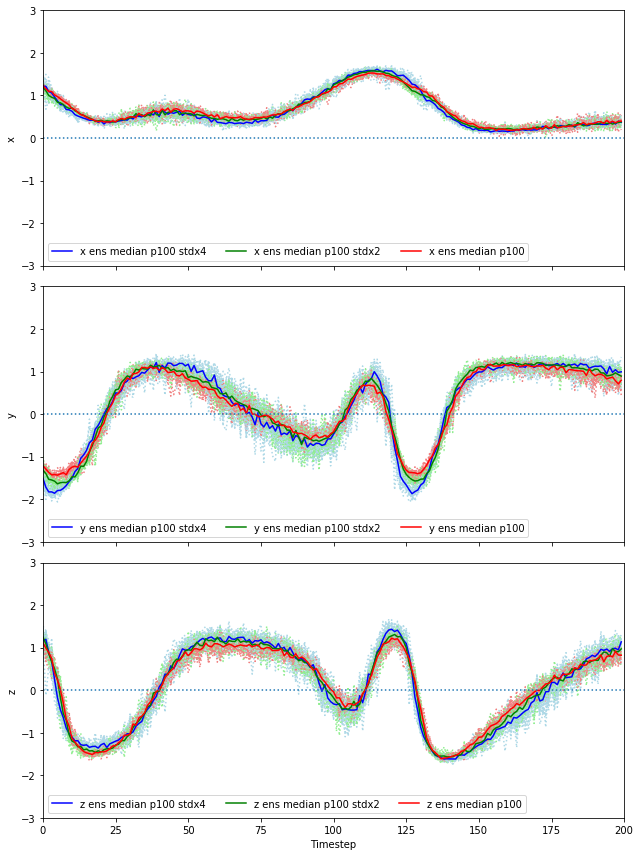

In [18]:
    #######################################################################################
    #########    visualization of lead time dependent prediction - std of prior   #########
    #######################################################################################
    index = np.arange(test_len) 
    print ('===================  visualize data  =====================')
    
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(9, 12, forward=True)
    # each member
    for i in range(ens):       
        ax1.plot(index, predictand_p100_stdx4[i, 0, :, 0] * (x_max - x_min) + x_min,
                 color='lightblue', linestyle='dotted')
        ax2.plot(index, predictand_p100_stdx4[i, 1, :, 0] * (y_max - y_min) + y_min,
                 color='lightblue', linestyle='dotted')
        ax3.plot(index, predictand_p100_stdx4[i, 2, :, 0] * (z_max - z_min) + z_min,
                 color='lightblue', linestyle='dotted')

        ax1.plot(index, predictand_p100_stdx2[i, 0, :, 0] * (x_max - x_min) + x_min,
                 color='lightgreen', linestyle='dotted')
        ax2.plot(index, predictand_p100_stdx2[i, 1, :, 0] * (y_max - y_min) + y_min,
                 color='lightgreen', linestyle='dotted')
        ax3.plot(index, predictand_p100_stdx2[i, 2, :, 0] * (z_max - z_min) + z_min,
                 color='lightgreen', linestyle='dotted')
        
        ax1.plot(index, predictand_p100[i, 0, :, 0] * (x_max - x_min) + x_min,
                 color='lightcoral', linestyle='dotted')
        ax2.plot(index, predictand_p100[i, 1, :, 0] * (y_max - y_min) + y_min,
                 color='lightcoral', linestyle='dotted')
        ax3.plot(index, predictand_p100[i, 2, :, 0] * (z_max - z_min) + z_min,
                 color='lightcoral', linestyle='dotted')
    # median
    ax1.plot(index, predictand_median_p100_stdx4[0, :, 0] * (x_max - x_min) + x_min,
             color='blue', linestyle='solid', label='x ens median p100 stdx4')
    ax2.plot(index, predictand_median_p100_stdx4[1, :, 0] * (y_max - y_min) + y_min,
             color='blue', linestyle='solid', label='y ens median p100 stdx4')
    ax3.plot(index, predictand_median_p100_stdx4[2, :, 0] * (z_max - z_min) + z_min,
             color='blue', linestyle='solid', label='z ens median p100 stdx4')

    ax1.plot(index, predictand_median_p100_stdx2[0, :, 0] * (x_max - x_min) + x_min,
             color='green', linestyle='solid', label='x ens median p100 stdx2')
    ax2.plot(index, predictand_median_p100_stdx2[1, :, 0] * (y_max - y_min) + y_min,
             color='green', linestyle='solid', label='y ens median p100 stdx2')
    ax3.plot(index, predictand_median_p100_stdx2[2, :, 0] * (z_max - z_min) + z_min,
             color='green', linestyle='solid', label='z ens median p100 stdx2')    
    
    ax1.plot(index, predictand_median_p100[0, :, 0] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x ens median p100')
    ax2.plot(index, predictand_median_p100[1, :, 0] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y ens median p100')
    ax3.plot(index, predictand_median_p100[2, :, 0] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z ens median p100')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10}, ncol=3)
    ax2.legend(frameon=True, loc=3, prop={'size': 10}, ncol=3)
    ax3.legend(frameon=True, loc=3, prop={'size': 10}, ncol=3)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()

    plt.show()
    fig03.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_ens_comp_std.png'),dpi=200)

===================  load data  =====================
===================  visualize data  =====================


<Figure size 432x288 with 0 Axes>

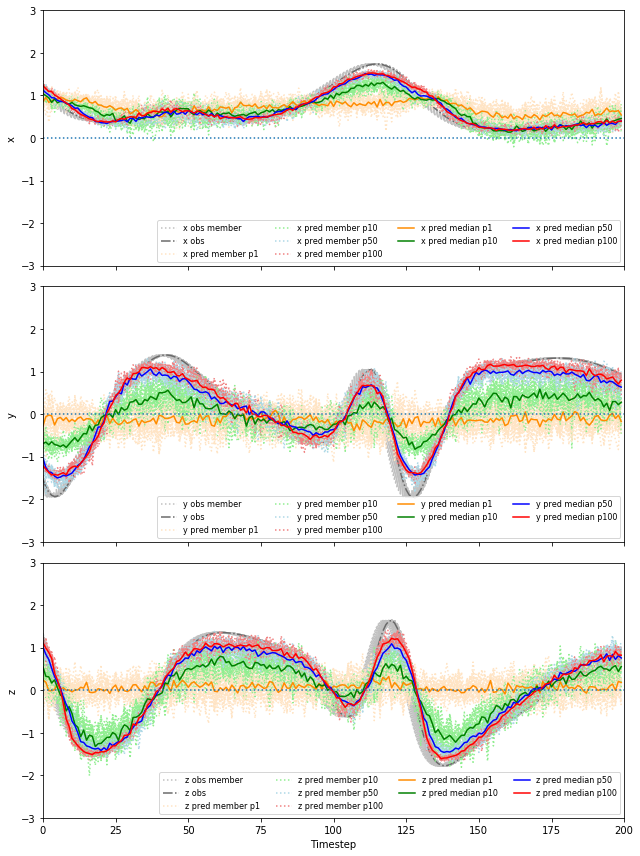

In [17]:
    #############################################################################################################
    ###########        Comparison Lorenz 84 model ensemble output and BayesConvLSTM forecast          ###########
    #############################################################################################################
    print ('===================  load data  =====================')
    # save Lorens model output
    index = np.arange(test_len)
    # number of ensembles
    ens = 20
    ens_obs = 51
    data_ens = np.zeros((ens_obs, 3, test_len), dtype=float)
    # load data
    for i in range(ens_obs):
        dataset = Dataset(os.path.join(data_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))   
        data_ens[i,:,:] = dataset.variables['series'][:, -test_len:]

    print ('===================  visualize data  =====================')
    ##################################################################
    ###########        Time series of testing data         ###########
    ##################################################################
    fig04 = plt.figure()
    fig04, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig04.set_size_inches(9, 12, forward=True)
    
    # Lorenz 84 model time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='silver', linestyle='dotted', label='x obs member')
            ax2.plot(index, data_ens[i, 1, :], color='silver', linestyle='dotted',label='y obs member')
            ax3.plot(index, data_ens[i, 2, :], color='silver', linestyle='dotted',label='z obs member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='silver', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='silver', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='silver', linestyle='dotted')
    
    # without perturbation
    #ax1.plot(index, np.median(data_ens[:, 0, :], 0), color='blue', linestyle='dashdot', label='x obs')
    ax1.plot(index, data_ens[24, 0, :], color='dimgray', linestyle='dashdot', label='x obs')
    #ax2.plot(index, np.median(data_ens[:, 1, :], 0), color='blue', linestyle='dashdot', label='y obs').
    ax2.plot(index, data_ens[24, 1, :], color='dimgray', linestyle='dashdot', label='y obs')
    #ax3.plot(index, np.median(data_ens[:, 2, :], 0), color='blue', linestyle='dashdot', label='z obs')
    ax3.plot(index, data_ens[24, 2, :], color='dimgray', linestyle='dashdot', label='z obs')

    # forecast time series
    for i in range(ens):
        if i == 0: # for the legend
            ax1.plot(index, predictand_p1[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='bisque', linestyle='dotted', label='x pred member p1')
            ax2.plot(index, predictand_p1[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='bisque', linestyle='dotted', label='y pred member p1')
            ax3.plot(index, predictand_p1[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='bisque', linestyle='dotted', label='z pred member p1')

            ax1.plot(index, predictand_p10[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightgreen', linestyle='dotted', label='x pred member p10')
            ax2.plot(index, predictand_p10[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightgreen', linestyle='dotted', label='y pred member p10')
            ax3.plot(index, predictand_p10[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightgreen', linestyle='dotted', label='z pred member p10')

            ax1.plot(index, predictand_p50[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightblue', linestyle='dotted', label='x pred member p50')
            ax2.plot(index, predictand_p50[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightblue', linestyle='dotted', label='y pred member p50')
            ax3.plot(index, predictand_p50[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightblue', linestyle='dotted', label='z pred member p50')
        
            ax1.plot(index, predictand_p100[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightcoral', linestyle='dotted', label='x pred member p100')
            ax2.plot(index, predictand_p100[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightcoral', linestyle='dotted', label='y pred member p100')
            ax3.plot(index, predictand_p100[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightcoral', linestyle='dotted', label='z pred member p100')

        else: 
            ax1.plot(index, predictand_p1[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='bisque', linestyle='dotted')
            ax2.plot(index, predictand_p1[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='bisque', linestyle='dotted')
            ax3.plot(index, predictand_p1[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='bisque', linestyle='dotted')

            ax1.plot(index, predictand_p10[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightgreen', linestyle='dotted')
            ax2.plot(index, predictand_p10[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightgreen', linestyle='dotted')
            ax3.plot(index, predictand_p10[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightgreen', linestyle='dotted')

            ax1.plot(index, predictand_p50[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightblue', linestyle='dotted')
            ax2.plot(index, predictand_p50[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightblue', linestyle='dotted')
            ax3.plot(index, predictand_p50[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightblue', linestyle='dotted')
        
            ax1.plot(index, predictand_p100[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightcoral', linestyle='dotted')
            ax2.plot(index, predictand_p100[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightcoral', linestyle='dotted')
            ax3.plot(index, predictand_p100[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightcoral', linestyle='dotted')

    # median forecast time series
    ax1.plot(index, predictand_median_p1[0, :, 0] * (x_max - x_min) + x_min,
             color='darkorange', linestyle='solid', label='x pred median p1')
    ax2.plot(index, predictand_median_p1[1, :, 0] * (y_max - y_min) + y_min,
             color='darkorange', linestyle='solid', label='y pred median p1')
    ax3.plot(index, predictand_median_p1[2, :, 0] * (z_max - z_min) + z_min,
             color='darkorange', linestyle='solid', label='z pred median p1')

    ax1.plot(index, predictand_median_p10[0, :, 0] * (x_max - x_min) + x_min,
             color='green', linestyle='solid', label='x pred median p10')
    ax2.plot(index, predictand_median_p10[1, :, 0] * (y_max - y_min) + y_min,
             color='green', linestyle='solid', label='y pred median p10')
    ax3.plot(index, predictand_median_p10[2, :, 0] * (z_max - z_min) + z_min,
             color='green', linestyle='solid', label='z pred median p10')

    ax1.plot(index, predictand_median_p50[0, :, 0] * (x_max - x_min) + x_min,
             color='blue', linestyle='solid', label='x pred median p50')
    ax2.plot(index, predictand_median_p50[1, :, 0] * (y_max - y_min) + y_min,
             color='blue', linestyle='solid', label='y pred median p50')
    ax3.plot(index, predictand_median_p50[2, :, 0] * (z_max - z_min) + z_min,
             color='blue', linestyle='solid', label='z pred median p50')
    
    ax1.plot(index, predictand_median_p100[0, :, 0] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x pred median p100')
    ax2.plot(index, predictand_median_p100[1, :, 0] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y pred median p100')
    ax3.plot(index, predictand_median_p100[2, :, 0] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z pred median p100')          
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=4, prop={'size': 8}, ncol=4)
    ax2.legend(frameon=True, loc=4, prop={'size': 8}, ncol=4)
    ax3.legend(frameon=True, loc=4, prop={'size': 8}, ncol=4)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()

    plt.show()
    fig04.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_comp_ens_penalty_obs.png'),dpi=200)

===================  load data  =====================
===================  visualize data  =====================


<Figure size 432x288 with 0 Axes>

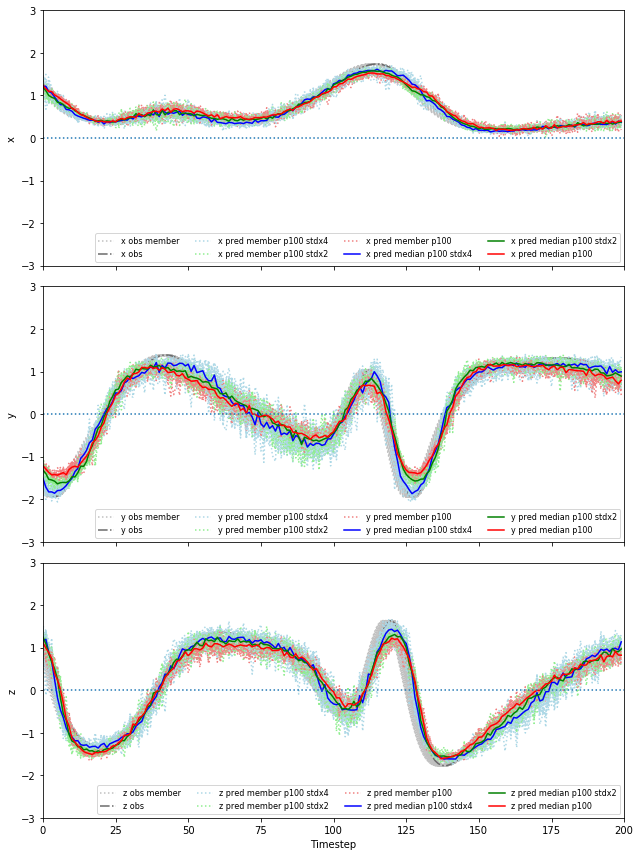

In [20]:
    #############################################################################################################
    ###########        Comparison Lorenz 84 model ensemble output and BayesConvLSTM forecast          ###########
    #############################################################################################################
    print ('===================  load data  =====================')
    # save Lorens model output
    index = np.arange(test_len)
    # number of ensembles
    ens = 20
    ens_obs = 51
    data_ens = np.zeros((ens_obs, 3, test_len), dtype=float)
    # load data
    for i in range(ens_obs):
        dataset = Dataset(os.path.join(data_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))   
        data_ens[i,:,:] = dataset.variables['series'][:, -test_len:]

    print ('===================  visualize data  =====================')
    ##################################################################
    ###########        Time series of testing data         ###########
    ##################################################################
    fig04 = plt.figure()
    fig04, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig04.set_size_inches(9, 12, forward=True)
    
    # Lorenz 84 model time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='silver', linestyle='dotted', label='x obs member')
            ax2.plot(index, data_ens[i, 1, :], color='silver', linestyle='dotted',label='y obs member')
            ax3.plot(index, data_ens[i, 2, :], color='silver', linestyle='dotted',label='z obs member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='silver', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='silver', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='silver', linestyle='dotted')
    
    # without perturbation
    #ax1.plot(index, np.median(data_ens[:, 0, :], 0), color='blue', linestyle='dashdot', label='x obs')
    ax1.plot(index, data_ens[24, 0, :], color='dimgray', linestyle='dashdot', label='x obs')
    #ax2.plot(index, np.median(data_ens[:, 1, :], 0), color='blue', linestyle='dashdot', label='y obs').
    ax2.plot(index, data_ens[24, 1, :], color='dimgray', linestyle='dashdot', label='y obs')
    #ax3.plot(index, np.median(data_ens[:, 2, :], 0), color='blue', linestyle='dashdot', label='z obs')
    ax3.plot(index, data_ens[24, 2, :], color='dimgray', linestyle='dashdot', label='z obs')

    # forecast time series
    for i in range(ens):
        if i == 0: # for the legend
            ax1.plot(index, predictand_p100_stdx4[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightblue', linestyle='dotted', label='x pred member p100 stdx4')
            ax2.plot(index, predictand_p100_stdx4[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightblue', linestyle='dotted', label='y pred member p100 stdx4')
            ax3.plot(index, predictand_p100_stdx4[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightblue', linestyle='dotted', label='z pred member p100 stdx4')

            ax1.plot(index, predictand_p100_stdx2[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightgreen', linestyle='dotted', label='x pred member p100 stdx2')
            ax2.plot(index, predictand_p100_stdx2[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightgreen', linestyle='dotted', label='y pred member p100 stdx2')
            ax3.plot(index, predictand_p100_stdx2[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightgreen', linestyle='dotted', label='z pred member p100 stdx2')            
            
            ax1.plot(index, predictand_p100[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightcoral', linestyle='dotted', label='x pred member p100')
            ax2.plot(index, predictand_p100[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightcoral', linestyle='dotted', label='y pred member p100')
            ax3.plot(index, predictand_p100[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightcoral', linestyle='dotted', label='z pred member p100')

        else: 
            ax1.plot(index, predictand_p100_stdx4[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightblue', linestyle='dotted')
            ax2.plot(index, predictand_p100_stdx4[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightblue', linestyle='dotted')
            ax3.plot(index, predictand_p100_stdx4[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightblue', linestyle='dotted')
            
            ax1.plot(index, predictand_p100_stdx2[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightgreen', linestyle='dotted')
            ax2.plot(index, predictand_p100_stdx2[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightgreen', linestyle='dotted')
            ax3.plot(index, predictand_p100_stdx2[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightgreen', linestyle='dotted')            
        
            ax1.plot(index, predictand_p100[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightcoral', linestyle='dotted')
            ax2.plot(index, predictand_p100[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightcoral', linestyle='dotted')
            ax3.plot(index, predictand_p100[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightcoral', linestyle='dotted')

    # median forecast time series
    ax1.plot(index, predictand_median_p100_stdx4[0, :, 0] * (x_max - x_min) + x_min,
             color='blue', linestyle='solid', label='x pred median p100 stdx4')
    ax2.plot(index, predictand_median_p100_stdx4[1, :, 0] * (y_max - y_min) + y_min,
             color='blue', linestyle='solid', label='y pred median p100 stdx4')
    ax3.plot(index, predictand_median_p100_stdx4[2, :, 0] * (z_max - z_min) + z_min,
             color='blue', linestyle='solid', label='z pred median p100 stdx4')    

    ax1.plot(index, predictand_median_p100_stdx2[0, :, 0] * (x_max - x_min) + x_min,
             color='green', linestyle='solid', label='x pred median p100 stdx2')
    ax2.plot(index, predictand_median_p100_stdx2[1, :, 0] * (y_max - y_min) + y_min,
             color='green', linestyle='solid', label='y pred median p100 stdx2')
    ax3.plot(index, predictand_median_p100_stdx2[2, :, 0] * (z_max - z_min) + z_min,
             color='green', linestyle='solid', label='z pred median p100 stdx2')    
    
    ax1.plot(index, predictand_median_p100[0, :, 0] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x pred median p100')
    ax2.plot(index, predictand_median_p100[1, :, 0] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y pred median p100')
    ax3.plot(index, predictand_median_p100[2, :, 0] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z pred median p100')       

    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=4, prop={'size': 8}, ncol=4)
    ax2.legend(frameon=True, loc=4, prop={'size': 8}, ncol=4)
    ax3.legend(frameon=True, loc=4, prop={'size': 8}, ncol=4)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()

    plt.show()
    fig04.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_comp_ens_std_obs.png'),dpi=200)

<Figure size 432x288 with 0 Axes>

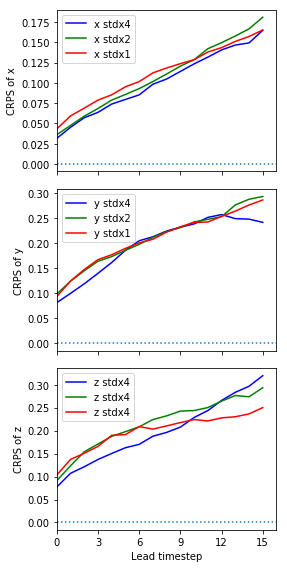

In [13]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    step_lead = 16
    # lead time dependent CRPS
    crps_mean_lead_stdx4 = np.zeros((step_lead,3), dtype=float)
    crps_mean_lead_stdx2 = np.zeros((step_lead,3), dtype=float)
    crps_mean_lead_p100 = np.zeros((step_lead,3), dtype=float)
    for i in range(step_lead):
        if i == 0:
            _, crps_mean_lead_stdx4[i,0] = dlacs.metric.CRPS(x[-test_len:], predictand_p100_stdx4[:,0,:,i]* (x_max - x_min) + x_min)
            _, crps_mean_lead_stdx4[i,1] = dlacs.metric.CRPS(y[-test_len:], predictand_p100_stdx4[:,1,:,i]* (y_max - y_min) + y_min)
            _, crps_mean_lead_stdx4[i,2] = dlacs.metric.CRPS(z[-test_len:], predictand_p100_stdx4[:,2,:,i]* (z_max - z_min) + z_min)

            _, crps_mean_lead_stdx2[i,0] = dlacs.metric.CRPS(x[-test_len:], predictand_p100_stdx2[:,0,:,i]* (x_max - x_min) + x_min)
            _, crps_mean_lead_stdx2[i,1] = dlacs.metric.CRPS(y[-test_len:], predictand_p100_stdx2[:,1,:,i]* (y_max - y_min) + y_min)
            _, crps_mean_lead_stdx2[i,2] = dlacs.metric.CRPS(z[-test_len:], predictand_p100_stdx2[:,2,:,i]* (z_max - z_min) + z_min)

            _, crps_mean_lead_p100[i,0] = dlacs.metric.CRPS(x[-test_len:], predictand_p100[:,0,:,i]* (x_max - x_min) + x_min)
            _, crps_mean_lead_p100[i,1] = dlacs.metric.CRPS(y[-test_len:], predictand_p100[:,1,:,i]* (y_max - y_min) + y_min)
            _, crps_mean_lead_p100[i,2] = dlacs.metric.CRPS(z[-test_len:], predictand_p100[:,2,:,i]* (z_max - z_min) + z_min)
        else:
            _, crps_mean_lead_stdx4[i,0] = dlacs.metric.CRPS(x[-test_len+i:], predictand_p100_stdx4[:,0,:-i,i]* (x_max - x_min) + x_min)
            _, crps_mean_lead_stdx4[i,1] = dlacs.metric.CRPS(y[-test_len+i:], predictand_p100_stdx4[:,1,:-i,i]* (y_max - y_min) + y_min)
            _, crps_mean_lead_stdx4[i,2] = dlacs.metric.CRPS(z[-test_len+i:], predictand_p100_stdx4[:,2,:-i,i]* (z_max - z_min) + z_min)
            
            _, crps_mean_lead_stdx2[i,0] = dlacs.metric.CRPS(x[-test_len+i:], predictand_p100_stdx2[:,0,:-i,i]* (x_max - x_min) + x_min)
            _, crps_mean_lead_stdx2[i,1] = dlacs.metric.CRPS(y[-test_len+i:], predictand_p100_stdx2[:,1,:-i,i]* (y_max - y_min) + y_min)
            _, crps_mean_lead_stdx2[i,2] = dlacs.metric.CRPS(z[-test_len+i:], predictand_p100_stdx2[:,2,:-i,i]* (z_max - z_min) + z_min)

            _, crps_mean_lead_p100[i,0] = dlacs.metric.CRPS(x[-test_len+i:], predictand_p100[:,0,:-i,i]* (x_max - x_min) + x_min)
            _, crps_mean_lead_p100[i,1] = dlacs.metric.CRPS(y[-test_len+i:], predictand_p100[:,1,:-i,i]* (y_max - y_min) + y_min)
            _, crps_mean_lead_p100[i,2] = dlacs.metric.CRPS(z[-test_len+i:], predictand_p100[:,2,:-i,i]* (z_max - z_min) + z_min) 
    
    # Write CSV file
    with open(os.path.join(output_path, "CRPS_deter_std.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["x", "y", "z"])  # write header
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerow(["penalty 100 stdx4"])  # write header
        writer.writerows(crps_mean_lead_stdx4.T)
        writer.writerow(["penalty 100 stdx2"])  # write header
        writer.writerows(crps_mean_lead_p100.T)
        writer.writerow(["penalty 100 stdx1"])  # write header
        writer.writerows(crps_mean_lead_p100.T)
        
    index = np.arange(0, step_lead)
    
    fig07 = plt.figure()
    fig07, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig07.set_size_inches(4, 8, forward=True)
    ax1.plot(index, crps_mean_lead_stdx4[:,0], 'b', label='x stdx4')
    ax1.plot(index, crps_mean_lead_stdx2[:,0], 'g', label='x stdx2')
    ax1.plot(index, crps_mean_lead_p100[:,0], 'r', label='x stdx1')
    
    ax2.plot(index, crps_mean_lead_stdx4[:,1], 'b', label='y stdx4')
    ax2.plot(index, crps_mean_lead_stdx2[:,1], 'g', label='y stdx2')
    ax2.plot(index, crps_mean_lead_p100[:,1], 'r', label='y stdx1')
    
    ax3.plot(index, crps_mean_lead_stdx4[:,2], 'b', label='z stdx4')
    ax3.plot(index, crps_mean_lead_stdx2[:,2], 'g', label='z stdx4')
    ax3.plot(index, crps_mean_lead_p100[:,2], 'r', label='z stdx4')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, step_lead)
    ax2.set_xlim(0, step_lead)
    ax3.set_xlim(0, step_lead)
    
    ax1.set_xticks(np.arange(0,step_lead,3))
    ax2.set_xticks(np.arange(0,step_lead,3))
    ax3.set_xticks(np.arange(0,step_lead,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("CRPS of x")
    ax2.set_ylabel("CRPS of y")
    ax3.set_ylabel("CRPS of z")
    
    plt.xlabel("Lead timestep")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    
    plt.tight_layout()

    plt.show()
    fig07.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_CRPS_comp_loss_std.png'),dpi=200)